## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp004'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 8 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

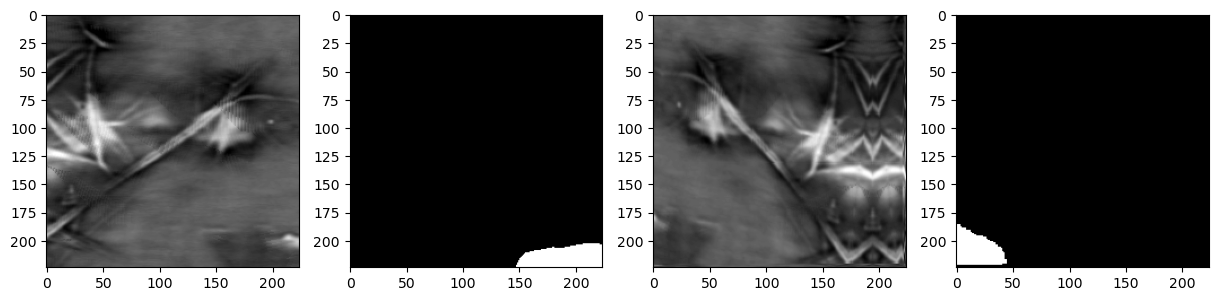

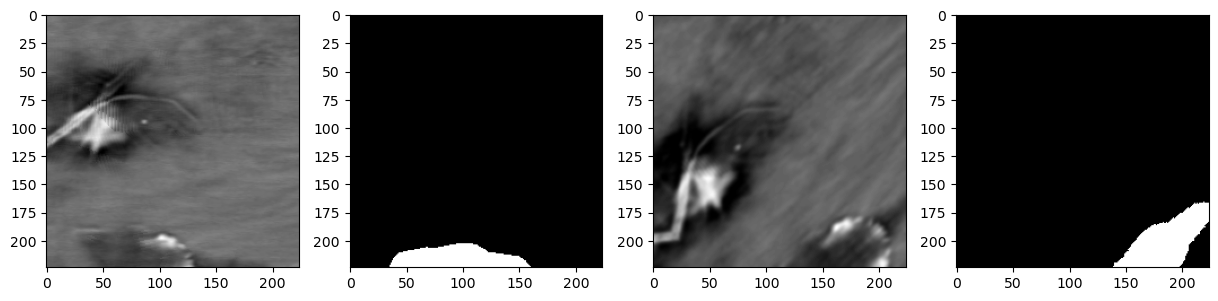

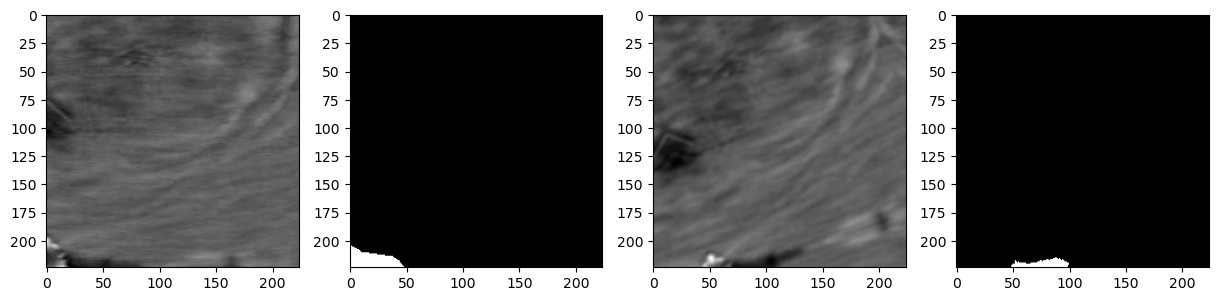

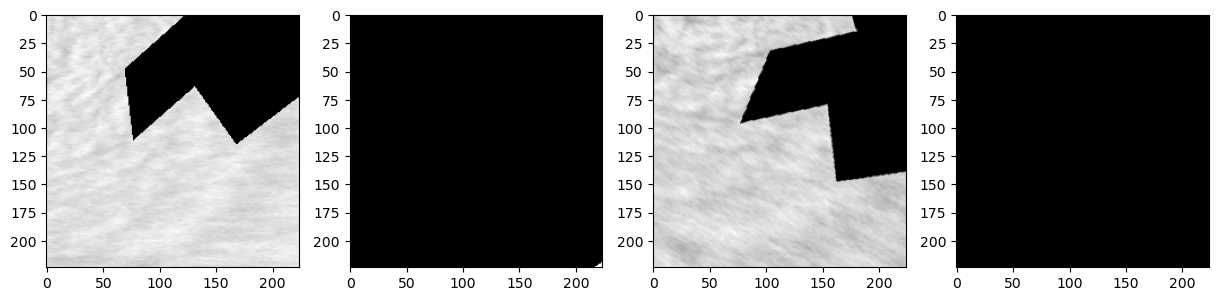

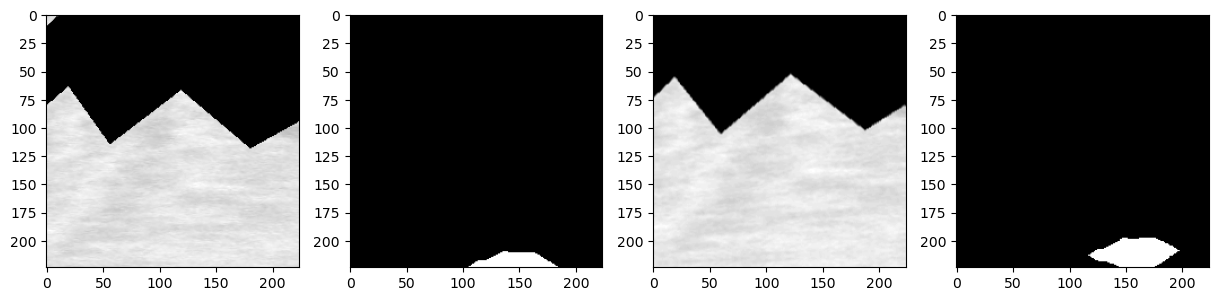

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48125

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12097844156667575
th: 0.15, fbeta: 0.1838470757875952
th: 0.2, fbeta: 0.23092018655960983
th: 0.25, fbeta: 0.2987991831221962
th: 0.3, fbeta: 0.37660897384673114
th: 0.35, fbeta: 0.41121454025269016
th: 0.4, fbeta: 0.4036273995459155
th: 0.45, fbeta: 0.3536839289121191


best_th: 0.35, fbeta: 0.41121454025269016
Epoch 1 - avg_train_loss: 0.4873  avg_val_loss: 0.3347  time: 201s
Epoch 1 - avgScore: 0.4112
Epoch 1 - Save Best Score: 0.4112 Model
Epoch 1 - Save Best Loss: 0.3347 Model


th: 0.5, fbeta: 0.24207648622403746


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21024366401011751
th: 0.15, fbeta: 0.2561665912435135
th: 0.2, fbeta: 0.342980681634672
th: 0.25, fbeta: 0.3984819622398567
th: 0.3, fbeta: 0.4234239010594518
th: 0.35, fbeta: 0.43637488346681735
th: 0.4, fbeta: 0.43890499123049126
th: 0.45, fbeta: 0.42616124397118865


best_th: 0.4, fbeta: 0.43890499123049126
Epoch 2 - avg_train_loss: 0.3272  avg_val_loss: 0.2812  time: 206s
Epoch 2 - avgScore: 0.4389
Epoch 2 - Save Best Score: 0.4389 Model
Epoch 2 - Save Best Loss: 0.2812 Model


th: 0.5, fbeta: 0.36636056369568354


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.27582071497492877
th: 0.15, fbeta: 0.29919521648380715
th: 0.2, fbeta: 0.3169242163720268
th: 0.25, fbeta: 0.3292687522429052
th: 0.3, fbeta: 0.33577377723733126
th: 0.35, fbeta: 0.3344213273906688
th: 0.4, fbeta: 0.31861970278028273
th: 0.45, fbeta: 0.19782680730556637


best_th: 0.3, fbeta: 0.33577377723733126
Epoch 3 - avg_train_loss: 0.2753  avg_val_loss: 0.2615  time: 205s
Epoch 3 - avgScore: 0.3358


th: 0.5, fbeta: 7.396139126321599e-05


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33113973717766815
th: 0.15, fbeta: 0.37066044983730134
th: 0.2, fbeta: 0.3978452789941951
th: 0.25, fbeta: 0.4205996508912091
th: 0.3, fbeta: 0.4387916110164087
th: 0.35, fbeta: 0.4547155959711783
th: 0.4, fbeta: 0.4667590492303884
th: 0.45, fbeta: 0.4709288441636856


best_th: 0.45, fbeta: 0.4709288441636856
Epoch 4 - avg_train_loss: 0.2560  avg_val_loss: 0.2392  time: 204s
Epoch 4 - avgScore: 0.4709
Epoch 4 - Save Best Score: 0.4709 Model
Epoch 4 - Save Best Loss: 0.2392 Model


th: 0.5, fbeta: 0.46889145124057996


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3862074425391367
th: 0.15, fbeta: 0.4381113107271298
th: 0.2, fbeta: 0.46667369428869326
th: 0.25, fbeta: 0.47239631752228106
th: 0.3, fbeta: 0.4716155660642184
th: 0.35, fbeta: 0.4632210371714233
th: 0.4, fbeta: 0.44445782870095635
th: 0.45, fbeta: 0.4148391579323727


best_th: 0.25, fbeta: 0.47239631752228106
Epoch 5 - avg_train_loss: 0.2441  avg_val_loss: 0.2494  time: 207s
Epoch 5 - avgScore: 0.4724
Epoch 5 - Save Best Score: 0.4724 Model
Epoch 5 - Save Best Loss: 0.2494 Model


th: 0.5, fbeta: 0.37641903232952245


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32814473176556913
th: 0.15, fbeta: 0.36180478652879683
th: 0.2, fbeta: 0.39207690646381144
th: 0.25, fbeta: 0.41814289678023825
th: 0.3, fbeta: 0.44154678618348553
th: 0.35, fbeta: 0.4630680684709318
th: 0.4, fbeta: 0.48210049323977355
th: 0.45, fbeta: 0.5003857399139361


best_th: 0.5, fbeta: 0.5151656291877379
Epoch 6 - avg_train_loss: 0.2353  avg_val_loss: 0.2359  time: 204s
Epoch 6 - avgScore: 0.5152
Epoch 6 - Save Best Score: 0.5152 Model
Epoch 6 - Save Best Loss: 0.2359 Model


th: 0.5, fbeta: 0.5151656291877379


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29844152380666217
th: 0.15, fbeta: 0.3292561983074719
th: 0.2, fbeta: 0.3534338846077472
th: 0.25, fbeta: 0.3754383738484471
th: 0.3, fbeta: 0.3957163332834021
th: 0.35, fbeta: 0.41462946537555295
th: 0.4, fbeta: 0.43156412594076277
th: 0.45, fbeta: 0.4452096717228537


best_th: 0.5, fbeta: 0.45469944560747977
Epoch 7 - avg_train_loss: 0.2265  avg_val_loss: 0.2558  time: 207s
Epoch 7 - avgScore: 0.4547


th: 0.5, fbeta: 0.45469944560747977


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.415310438780343
th: 0.15, fbeta: 0.4573477377214933
th: 0.2, fbeta: 0.4896475382800232
th: 0.25, fbeta: 0.5143906908560653
th: 0.3, fbeta: 0.5289149451724949
th: 0.35, fbeta: 0.5331274575545595
th: 0.4, fbeta: 0.52933508767375
th: 0.45, fbeta: 0.5201202181227894


best_th: 0.35, fbeta: 0.5331274575545595
Epoch 8 - avg_train_loss: 0.2191  avg_val_loss: 0.2337  time: 206s
Epoch 8 - avgScore: 0.5331
Epoch 8 - Save Best Score: 0.5331 Model
Epoch 8 - Save Best Loss: 0.2337 Model


th: 0.5, fbeta: 0.49854851415574597


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35054459955045886
th: 0.15, fbeta: 0.3794443518539075
th: 0.2, fbeta: 0.4001044081733159
th: 0.25, fbeta: 0.4252921339212687
th: 0.3, fbeta: 0.4430977621440546
th: 0.35, fbeta: 0.4457134960489458
th: 0.4, fbeta: 0.4297870034090761
th: 0.45, fbeta: 0.4032711475161345


best_th: 0.35, fbeta: 0.4457134960489458
Epoch 9 - avg_train_loss: 0.2101  avg_val_loss: 0.2473  time: 205s
Epoch 9 - avgScore: 0.4457


th: 0.5, fbeta: 0.3715263437176063


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37552317229002086
th: 0.15, fbeta: 0.40519335848973415
th: 0.2, fbeta: 0.4304763054544029
th: 0.25, fbeta: 0.44795057536587946
th: 0.3, fbeta: 0.46229744520492844
th: 0.35, fbeta: 0.4725645197266087
th: 0.4, fbeta: 0.48007133369907473
th: 0.45, fbeta: 0.48598673262304076


best_th: 0.5, fbeta: 0.4871146082370502
Epoch 10 - avg_train_loss: 0.2034  avg_val_loss: 0.2602  time: 206s
Epoch 10 - avgScore: 0.4871


th: 0.5, fbeta: 0.4871146082370502


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4445865199465655
th: 0.15, fbeta: 0.4752712438851087
th: 0.2, fbeta: 0.501611044263585
th: 0.25, fbeta: 0.5235430996669735
th: 0.3, fbeta: 0.5354310315822716
th: 0.35, fbeta: 0.5410911481037468
th: 0.4, fbeta: 0.5386668204260362
th: 0.45, fbeta: 0.5320746339082653


best_th: 0.35, fbeta: 0.5410911481037468
Epoch 11 - avg_train_loss: 0.1948  avg_val_loss: 0.2796  time: 207s
Epoch 11 - avgScore: 0.5411
Epoch 11 - Save Best Score: 0.5411 Model
Epoch 11 - Save Best Loss: 0.2796 Model


th: 0.5, fbeta: 0.5208247175434416


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38225792648508583
th: 0.15, fbeta: 0.41550351019729853
th: 0.2, fbeta: 0.4417131777235262
th: 0.25, fbeta: 0.4665782697917147
th: 0.3, fbeta: 0.4869271746169038
th: 0.35, fbeta: 0.5033253143804786
th: 0.4, fbeta: 0.515072651926245
th: 0.45, fbeta: 0.5219910056451653


best_th: 0.5, fbeta: 0.5220251096312094
Epoch 12 - avg_train_loss: 0.1860  avg_val_loss: 0.2490  time: 208s
Epoch 12 - avgScore: 0.5220


th: 0.5, fbeta: 0.5220251096312094


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39168009040764207
th: 0.15, fbeta: 0.4165393779769813
th: 0.2, fbeta: 0.4323937758158759
th: 0.25, fbeta: 0.4461557252924973
th: 0.3, fbeta: 0.4577545885346555
th: 0.35, fbeta: 0.4650187834292992
th: 0.4, fbeta: 0.4662608945071245
th: 0.45, fbeta: 0.4645535627084523


best_th: 0.4, fbeta: 0.4662608945071245
Epoch 13 - avg_train_loss: 0.1809  avg_val_loss: 0.2715  time: 207s
Epoch 13 - avgScore: 0.4663


th: 0.5, fbeta: 0.46189965114353937


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41504087641486076
th: 0.15, fbeta: 0.4303727631892109
th: 0.2, fbeta: 0.43829209022553595
th: 0.25, fbeta: 0.4425814588653818
th: 0.3, fbeta: 0.44360926542133566
th: 0.35, fbeta: 0.44130667620385716
th: 0.4, fbeta: 0.43731161806856156
th: 0.45, fbeta: 0.42937972497019167


best_th: 0.3, fbeta: 0.44360926542133566
Epoch 14 - avg_train_loss: 0.1739  avg_val_loss: 0.3221  time: 206s
Epoch 14 - avgScore: 0.4436


th: 0.5, fbeta: 0.42007375580735506


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.419346415405535
th: 0.15, fbeta: 0.4588410334300081
th: 0.2, fbeta: 0.4905035213044961
th: 0.25, fbeta: 0.5128938517801647
th: 0.3, fbeta: 0.5302148627705614
th: 0.35, fbeta: 0.5395516753141614
th: 0.4, fbeta: 0.5471782876276927
th: 0.45, fbeta: 0.5529042843548742


best_th: 0.5, fbeta: 0.5550924088345491
Epoch 15 - avg_train_loss: 0.1715  avg_val_loss: 0.2433  time: 205s
Epoch 15 - avgScore: 0.5551
Epoch 15 - Save Best Score: 0.5551 Model
Epoch 15 - Save Best Loss: 0.2433 Model


th: 0.5, fbeta: 0.5550924088345491


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4172413151641521
th: 0.15, fbeta: 0.4517202706471935
th: 0.2, fbeta: 0.47723759183994513
th: 0.25, fbeta: 0.4962709785506253
th: 0.3, fbeta: 0.5131418748591619
th: 0.35, fbeta: 0.525237406961877
th: 0.4, fbeta: 0.5312703640232096
th: 0.45, fbeta: 0.5347468592661836


best_th: 0.45, fbeta: 0.5347468592661836
Epoch 16 - avg_train_loss: 0.1576  avg_val_loss: 0.2611  time: 206s
Epoch 16 - avgScore: 0.5347


th: 0.5, fbeta: 0.5341887015823764


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3921012775953753
th: 0.15, fbeta: 0.41645155961090186
th: 0.2, fbeta: 0.4376666164811009
th: 0.25, fbeta: 0.4549510275908592
th: 0.3, fbeta: 0.4704496634029446
th: 0.35, fbeta: 0.4841852595872644
th: 0.4, fbeta: 0.49318717147500374
th: 0.45, fbeta: 0.49869877720236744


best_th: 0.5, fbeta: 0.5020898208990653
Epoch 17 - avg_train_loss: 0.1565  avg_val_loss: 0.2904  time: 206s
Epoch 17 - avgScore: 0.5021


th: 0.5, fbeta: 0.5020898208990653


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40430698498281437
th: 0.15, fbeta: 0.43376675488113525
th: 0.2, fbeta: 0.4576518062378755
th: 0.25, fbeta: 0.4784665635826315
th: 0.3, fbeta: 0.4978772111408201
th: 0.35, fbeta: 0.5123713815451147
th: 0.4, fbeta: 0.5220887222706393
th: 0.45, fbeta: 0.5258150165170957


best_th: 0.45, fbeta: 0.5258150165170957
Epoch 18 - avg_train_loss: 0.1435  avg_val_loss: 0.2783  time: 207s
Epoch 18 - avgScore: 0.5258


th: 0.5, fbeta: 0.5251059097402682


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40632384713594805
th: 0.15, fbeta: 0.4374890798714687
th: 0.2, fbeta: 0.4629889441638458
th: 0.25, fbeta: 0.4856459125946834
th: 0.3, fbeta: 0.5055147391199049
th: 0.35, fbeta: 0.5219044137325832
th: 0.4, fbeta: 0.5335075863090436
th: 0.45, fbeta: 0.5401354618158807


best_th: 0.5, fbeta: 0.5441805647784943
Epoch 19 - avg_train_loss: 0.1385  avg_val_loss: 0.2868  time: 207s
Epoch 19 - avgScore: 0.5442


th: 0.5, fbeta: 0.5441805647784943


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4044426930770625
th: 0.15, fbeta: 0.42645539373694674
th: 0.2, fbeta: 0.4471670293356366
th: 0.25, fbeta: 0.4683966896696191
th: 0.3, fbeta: 0.48512312349941983
th: 0.35, fbeta: 0.49855601954075984
th: 0.4, fbeta: 0.5105240151343512
th: 0.45, fbeta: 0.5187574426055981


best_th: 0.5, fbeta: 0.5232859537729121
Epoch 20 - avg_train_loss: 0.1335  avg_val_loss: 0.2896  time: 205s
Epoch 20 - avgScore: 0.5233


th: 0.5, fbeta: 0.5232859537729121


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4480600745057356
th: 0.15, fbeta: 0.477575823708705
th: 0.2, fbeta: 0.5010822127797977
th: 0.25, fbeta: 0.5189863746677331
th: 0.3, fbeta: 0.5319352314994342
th: 0.35, fbeta: 0.5416556129064544
th: 0.4, fbeta: 0.544849847072009
th: 0.45, fbeta: 0.5430754723136125


best_th: 0.4, fbeta: 0.544849847072009
Epoch 21 - avg_train_loss: 0.1268  avg_val_loss: 0.2905  time: 204s
Epoch 21 - avgScore: 0.5448


th: 0.5, fbeta: 0.5402542523087878


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3977347081333016
th: 0.15, fbeta: 0.43138228559774255
th: 0.2, fbeta: 0.4568937670810739
th: 0.25, fbeta: 0.4801260228919196
th: 0.3, fbeta: 0.4979236622609749
th: 0.35, fbeta: 0.5145891276031158
th: 0.4, fbeta: 0.525636357339422
th: 0.45, fbeta: 0.5342999303872602


best_th: 0.5, fbeta: 0.5368636476968539
Epoch 22 - avg_train_loss: 0.1225  avg_val_loss: 0.2840  time: 205s
Epoch 22 - avgScore: 0.5369


th: 0.5, fbeta: 0.5368636476968539


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3870329487819541
th: 0.15, fbeta: 0.41310402846893274
th: 0.2, fbeta: 0.43535798253716906
th: 0.25, fbeta: 0.454462864449699
th: 0.3, fbeta: 0.4698477437172056
th: 0.35, fbeta: 0.4813138156065675
th: 0.4, fbeta: 0.49233626894943694
th: 0.45, fbeta: 0.500077165971005


best_th: 0.5, fbeta: 0.5038453701486668
Epoch 23 - avg_train_loss: 0.1167  avg_val_loss: 0.3044  time: 208s
Epoch 23 - avgScore: 0.5038


th: 0.5, fbeta: 0.5038453701486668


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40434933212113755
th: 0.15, fbeta: 0.4318996679337074
th: 0.2, fbeta: 0.45756153637470637
th: 0.25, fbeta: 0.477610118816882
th: 0.3, fbeta: 0.4956415864155671
th: 0.35, fbeta: 0.511318076076184
th: 0.4, fbeta: 0.5235612118258253
th: 0.45, fbeta: 0.531726080109698


best_th: 0.5, fbeta: 0.5366481352663324
Epoch 24 - avg_train_loss: 0.1129  avg_val_loss: 0.3187  time: 205s
Epoch 24 - avgScore: 0.5366


th: 0.5, fbeta: 0.5366481352663324


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44104872664850886
th: 0.15, fbeta: 0.47465349435406334
th: 0.2, fbeta: 0.49944384920528956
th: 0.25, fbeta: 0.5171437535331045
th: 0.3, fbeta: 0.5279510924767961
th: 0.35, fbeta: 0.5348052254076772
th: 0.4, fbeta: 0.5381710683137322
th: 0.45, fbeta: 0.5390969328433403


best_th: 0.45, fbeta: 0.5390969328433403
Epoch 25 - avg_train_loss: 0.1083  avg_val_loss: 0.3279  time: 207s
Epoch 25 - avgScore: 0.5391


th: 0.5, fbeta: 0.5355036654007919


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4133798040957054
th: 0.15, fbeta: 0.4440424688927783
th: 0.2, fbeta: 0.4715292279825793
th: 0.25, fbeta: 0.49359173240410986
th: 0.3, fbeta: 0.5075150291330969
th: 0.35, fbeta: 0.5146165841380237
th: 0.4, fbeta: 0.5183620830754803
th: 0.45, fbeta: 0.5194693901198999


best_th: 0.45, fbeta: 0.5194693901198999
Epoch 26 - avg_train_loss: 0.1057  avg_val_loss: 0.3248  time: 206s
Epoch 26 - avgScore: 0.5195


th: 0.5, fbeta: 0.5167760498612773


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3966607250838305
th: 0.15, fbeta: 0.4241431945473831
th: 0.2, fbeta: 0.4457132815243416
th: 0.25, fbeta: 0.4666286827547528
th: 0.3, fbeta: 0.48308229788595963
th: 0.35, fbeta: 0.4952674258860453
th: 0.4, fbeta: 0.5032963661044874
th: 0.45, fbeta: 0.5088277301843055


best_th: 0.5, fbeta: 0.5109923103751498
Epoch 27 - avg_train_loss: 0.1033  avg_val_loss: 0.3130  time: 206s
Epoch 27 - avgScore: 0.5110


th: 0.5, fbeta: 0.5109923103751498


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44454499395693514
th: 0.15, fbeta: 0.47399986177821085
th: 0.2, fbeta: 0.49691920039551246
th: 0.25, fbeta: 0.5146046355626789
th: 0.3, fbeta: 0.5245092221124543
th: 0.35, fbeta: 0.5305032478565611
th: 0.4, fbeta: 0.5352318854442883
th: 0.45, fbeta: 0.539023886286924


best_th: 0.45, fbeta: 0.539023886286924
Epoch 28 - avg_train_loss: 0.1027  avg_val_loss: 0.3276  time: 204s
Epoch 28 - avgScore: 0.5390


th: 0.5, fbeta: 0.5370576819850541


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42392665939986673
th: 0.15, fbeta: 0.45025173399045604
th: 0.2, fbeta: 0.4695930464959826
th: 0.25, fbeta: 0.4844996902748316
th: 0.3, fbeta: 0.49455262155159524
th: 0.35, fbeta: 0.4996415478657073
th: 0.4, fbeta: 0.5032325403655806
th: 0.45, fbeta: 0.5024056542088657


best_th: 0.4, fbeta: 0.5032325403655806
Epoch 29 - avg_train_loss: 0.1005  avg_val_loss: 0.3520  time: 204s
Epoch 29 - avgScore: 0.5032


th: 0.5, fbeta: 0.49937899221049714


  0%|          | 0/1806 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41028511572613624
th: 0.15, fbeta: 0.4384292359783238
th: 0.2, fbeta: 0.46228140251412486
th: 0.25, fbeta: 0.481691522471204
th: 0.3, fbeta: 0.49434324418785136
th: 0.35, fbeta: 0.5048236923389717
th: 0.4, fbeta: 0.5131480346671223
th: 0.45, fbeta: 0.519603175525905


best_th: 0.5, fbeta: 0.5213012189767834
Epoch 30 - avg_train_loss: 0.0991  avg_val_loss: 0.3295  time: 203s
Epoch 30 - avgScore: 0.5213


th: 0.5, fbeta: 0.5213012189767834


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.419346415405535
th: 0.15, fbeta: 0.4588410334300081
th: 0.2, fbeta: 0.4905035213044961
th: 0.25, fbeta: 0.5128938517801647
th: 0.3, fbeta: 0.5302148627705614
th: 0.35, fbeta: 0.5395516753141614
th: 0.4, fbeta: 0.5471782876276927
th: 0.45, fbeta: 0.5529042843548742


best_th: 0.5, fbeta: 0.5550924088345491


th: 0.5, fbeta: 0.5550924088345491


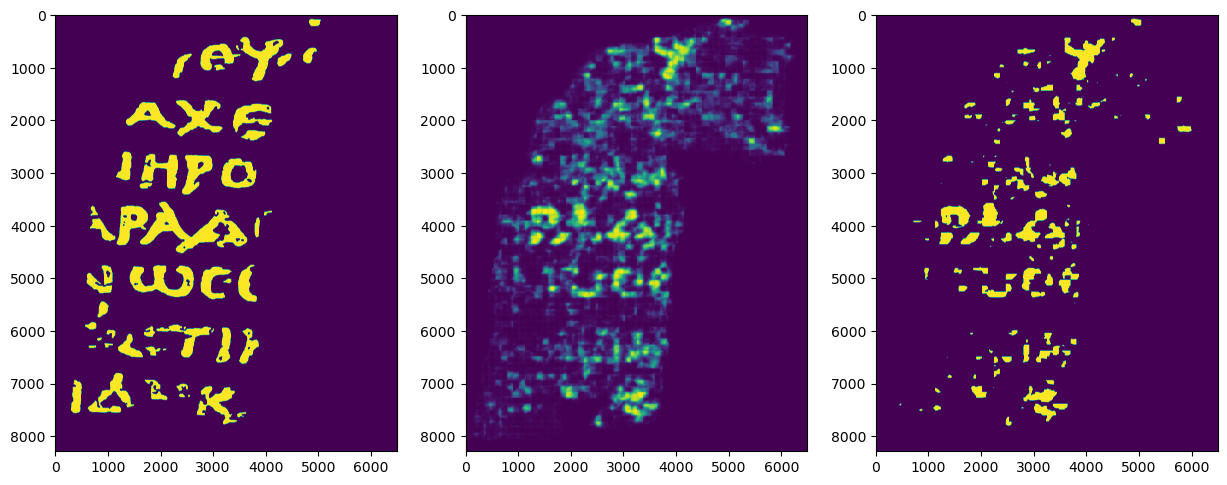

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([40048174.,  3609601.,  2045592.,  1411456.,  1086272.,   894757.,
          714308.,   583954.,   490971.,   406318.,   351155.,   320804.,
          301482.,   283051.,   251407.,   233433.,   237881.,   224799.,
          214118.,   129315.]),
 array([9.48637824e-08, 4.99214299e-02, 9.98427649e-02, 1.49764100e-01,
        1.99685435e-01, 2.49606770e-01, 2.99528105e-01, 3.49449440e-01,
        3.99370775e-01, 4.49292110e-01, 4.99213445e-01, 5.49134780e-01,
        5.99056115e-01, 6.48977450e-01, 6.98898785e-01, 7.48820120e-01,
        7.98741455e-01, 8.48662790e-01, 8.98584125e-01, 9.48505460e-01,
        9.98426795e-01]),
 <BarContainer object of 20 artists>)

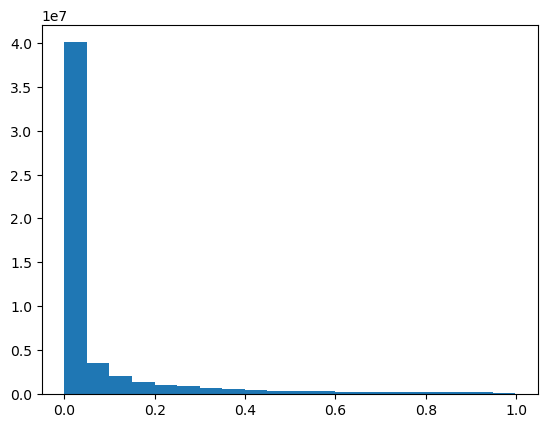

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000